# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 2 hours**. For this time interval, using the values of the **4 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Read the datasets

In [2]:
data1 = pd.read_csv("power_consumption_g3_feat.csv")
data1.sample(5)

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
9665,2017-08-14 09:30:00,23.86,47.66,4.907,532.300,83.900
32176,2017-03-04 07:00:00,14.34,86.60,4.913,0.048,0.093
35014,2017-08-01 14:20:00,28.23,73.50,4.905,796.000,196.000
10308,2017-03-15 23:20:00,11.65,NaN,0.087,0.088,0.108
37445,2017-12-18 00:50:00,11.01,85.60,0.079,0.033,0.100


In [3]:
data2 = pd.read_csv("power_consumption_g3.csv")
data2.sample(5)

,Date,SolarPower
11470,2017-05-20 15:00:00,33603.14754
7875,2017-08-20 04:30:00,28652.96337
20168,2017-05-18 20:00:00,46268.85246
48713,2017-04-29 03:30:00,23399.61249
10715,2017-06-30 01:50:00,29696.42384


In [4]:
print(len(data1))
print(len(data2))

52416
52416


## Merge the datasets (and pre-processing if needed)

In [5]:
data = pd.merge(data1, data2, on='Date')

In [6]:
len(data)

52416

In [7]:
data = data.sort_values(by=['Date']).reset_index()

In [8]:
data.isnull().sum()

index                    0
Date                     0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
SolarPower               0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                52416 non-null  int64  
 1   Date                 52416 non-null  object 
 2   Temperature          51857 non-null  float64
 3   Humidity             51917 non-null  float64
 4   WindSpeed            51887 non-null  float64
 5   GeneralDiffuseFlows  51892 non-null  float64
 6   DiffuseFlows         51911 non-null  float64
 7   SolarPower           52416 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.2+ MB


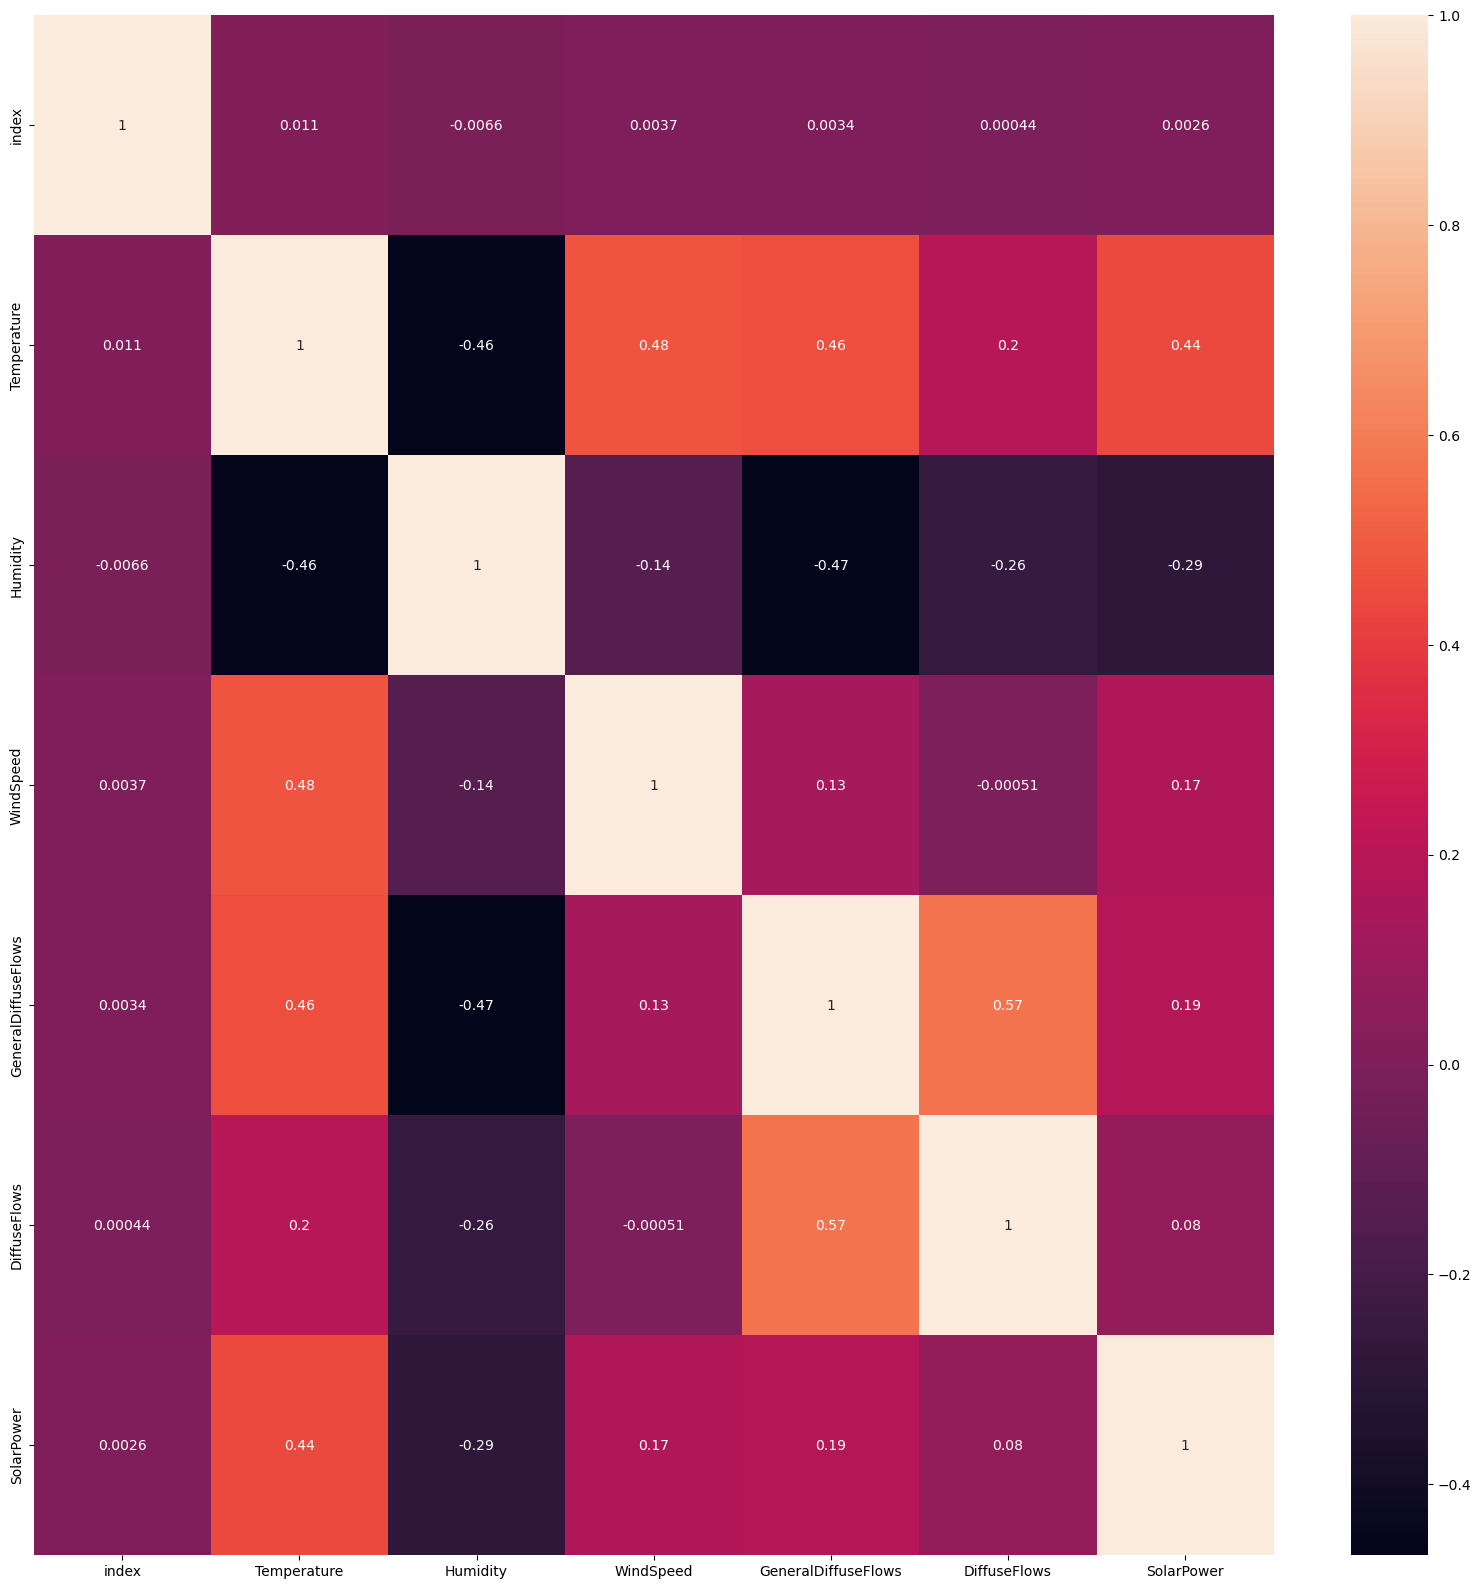

In [10]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.drop(columns='Date').corr(), annot=True)
plt.show()

In [11]:
data.isnull().sum()

index                    0
Date                     0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
SolarPower               0
dtype: int64

In [12]:
data.head()

,index,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
0,37462,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
1,37635,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2,19407,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
3,17609,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
4,27906,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


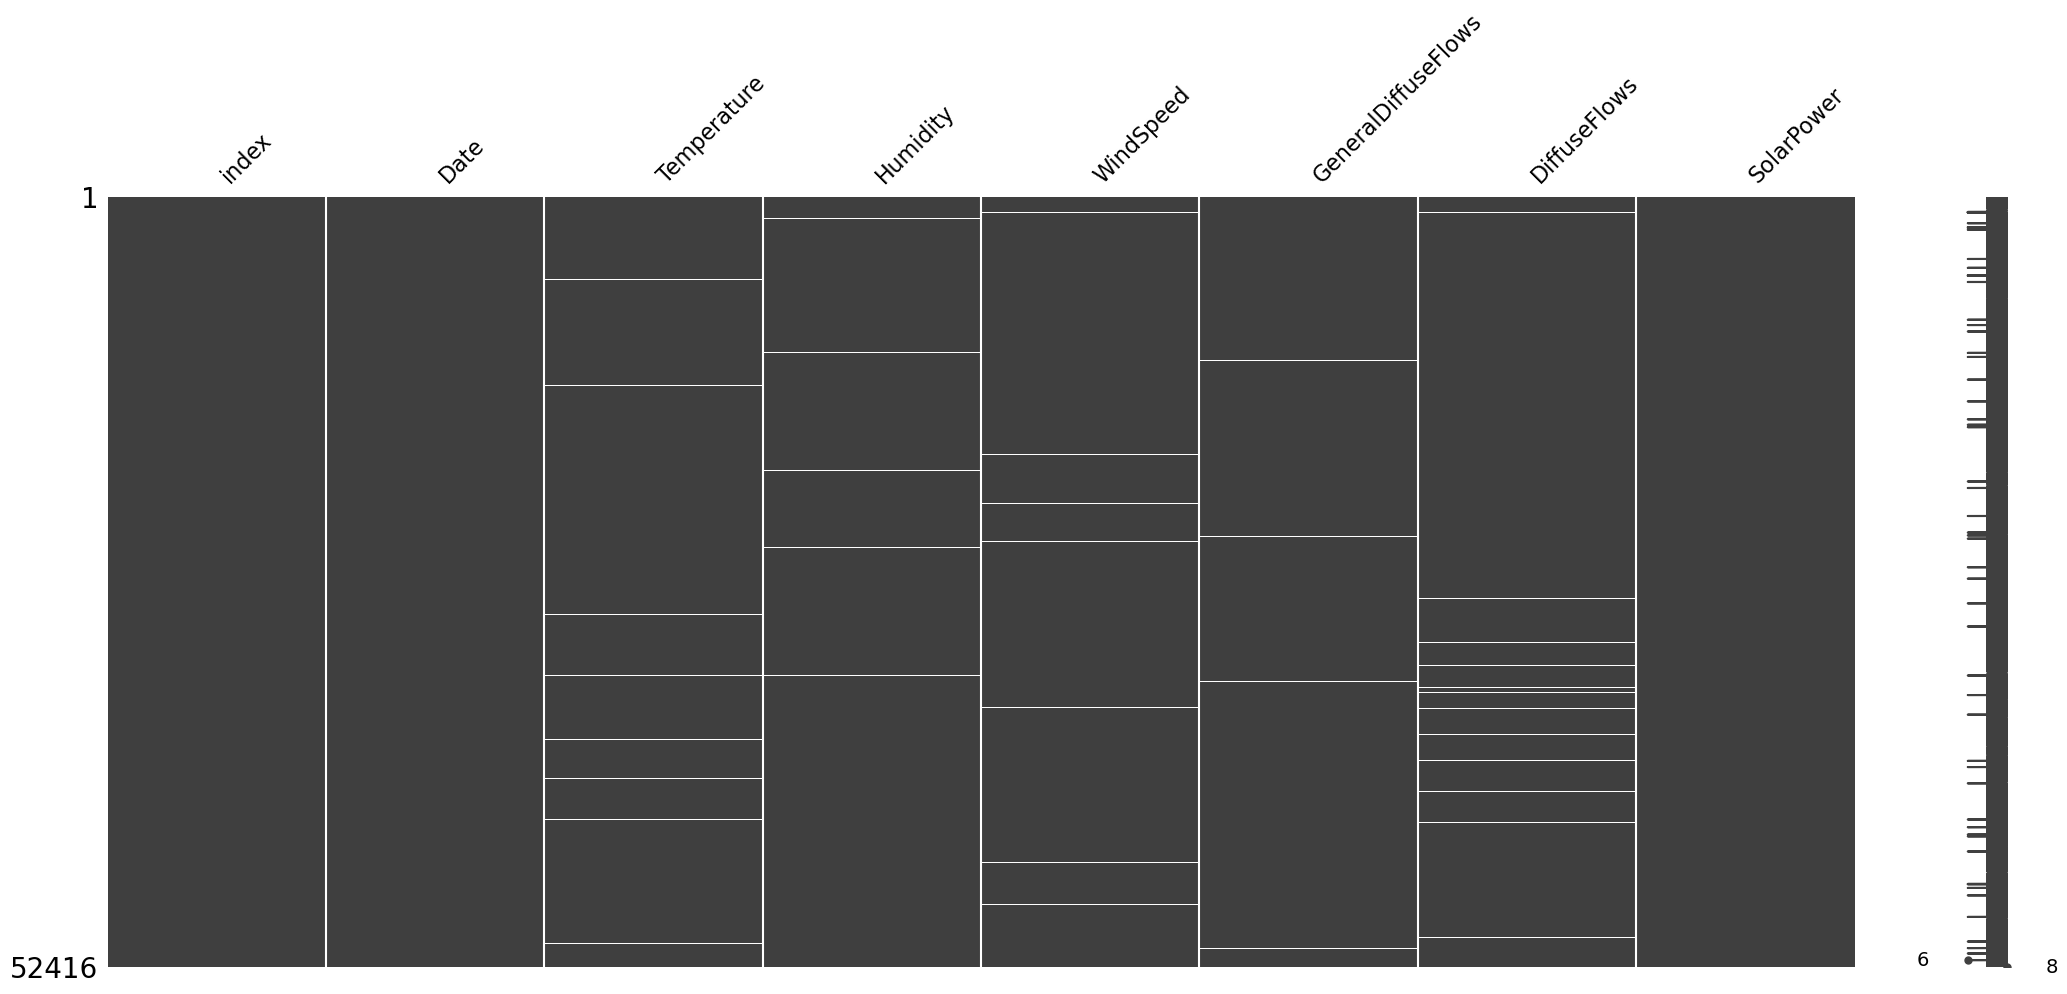

In [13]:
msno.matrix(data)
plt.show()

In [14]:
data['Humidity'] = data['Humidity'].bfill()

In [15]:
data['DiffuseFlows'] = data['DiffuseFlows'].ffill()

In [16]:
data['GeneralDiffuseFlows'] = data['GeneralDiffuseFlows'].ffill()

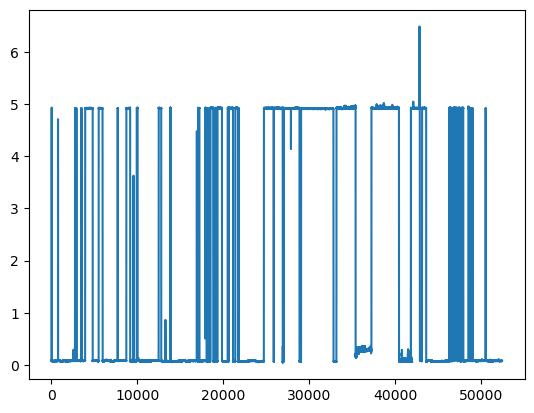

In [17]:
data['WindSpeed'].plot.line()
plt.show()

In [18]:
data['WindSpeed'] = data['WindSpeed'].interpolate(limit_direction='both')

In [19]:
data['Temperature'] = data['Temperature'].interpolate(limit_direction='both')

## Group the datasets into time intervals of 2 hours

In [20]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby(pd.Grouper(key='Date', freq='120min')).sum()

In [21]:
data.head()

,index,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,,
2017-01-01 00:00:00,355390,70.402,915.8,0.983,0.722,1.268,323131.13924
2017-01-01 02:00:00,299426,60.352,936.1,0.991,0.737,1.621,257365.06328
2017-01-01 04:00:00,336330,59.036,895.7,0.980,0.743,1.450,247698.22784
2017-01-01 06:00:00,281443,54.153,894.9,0.989,0.763,1.470,241136.20254
2017-01-01 08:00:00,323309,55.586,885.5,0.989,951.383,189.142,255062.27847


## Create lags

In [22]:
data['SP_lag1'] = data['SolarPower'].shift(1)
data['SP_lag2'] = data['SolarPower'].shift(2)
data['SP_lag3'] = data['SolarPower'].shift(3)
data['SP_lag4'] = data['SolarPower'].shift(4)

In [23]:
data = data.dropna().reset_index(drop=True)

In [24]:
data.head()

,index,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,SP_lag1,SP_lag2,SP_lag3,SP_lag4
0,323309,55.586,885.50,0.989,951.383,189.142,255062.27847,241136.20254,247698.22784,257365.06328,323131.13924
1,368905,96.232,766.03,34.960,4195.000,409.300,335842.02531,255062.27847,241136.20254,247698.22784,257365.06328
2,376333,183.160,684.90,0.914,5836.700,491.780,360729.11394,335842.02531,255062.27847,241136.20254,247698.22784
3,264969,187.950,682.97,0.908,4529.500,577.500,354701.77214,360729.11394,335842.02531,255062.27847,241136.20254
4,327672,183.710,709.35,0.927,1920.910,2037.280,378920.50632,354701.77214,360729.11394,335842.02531,255062.27847


In [26]:
def drop_data(data:pd.DataFrame, columns:list):
  data_copy = data.copy()
  data_copy.drop(columns, axis=1, inplace=True)
  return data_copy

In [27]:
data = drop_data(data=data, columns=['index'])

# Split the dataset into 80% training and 20% testing datasets

In [31]:
X = data.drop(['SolarPower'],axis=1)
Y = data['SolarPower']

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, shuffle=False,random_state=43)

## Create the model, pre-process the data and make it suitable for training

In [37]:
model = XGBRegressor()

## Perofrm hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [38]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv
)

In [39]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]})

## Fit the model with the best parameters on the training dataset

In [40]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, Y_train)
y_pred = best_model.predict(X_test)

## Calculate the adequate metrics on the testing dataset

In [43]:
r2 = r2_score(Y_test,y_pred)
r2

0.8958019979256024

In [45]:
mae = mean_absolute_error(Y_test, y_pred)
mae

17802.252821626575

In [47]:
mse = mean_squared_error(Y_test, y_pred)
mse

536637581.0640852

## Visualize the targets against the predictions

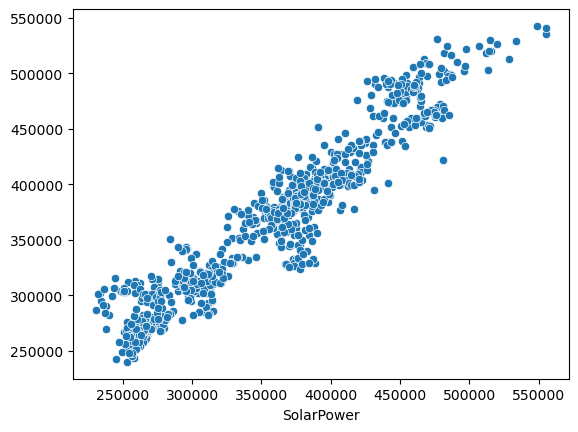

In [58]:
sns.scatterplot(x=Y_test, y=y_pred)
plt.show()